In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from torch_geometric.loader import DataLoader
from dataset_copy import *
from model import *
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
torch_geometric.seed_everything(23)
device = 'cpu'

Dataset type:  <class 'dataset_copy.ChiralLigands'>
Dataset node features:  7
Dataset length:  <bound method ChiralLigands.len of ChiralLigands(686)>
Dataset sample:  Data(x=[92, 7], edge_index=[2, 196], edge_attr=[196, 2], y=[1], category=[1], ligand='C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2', substrate='O=C1C=CCC1', boron='c1ccc(B2OB(c3ccccc3)OB(c3ccccc3)O2)cc1', ligand_num=1, ligand_id='L3.1', ligand_fam='fam1', idx=0)
Sample features:  tensor([[6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 4., 4., 0., 1., 1., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3.,

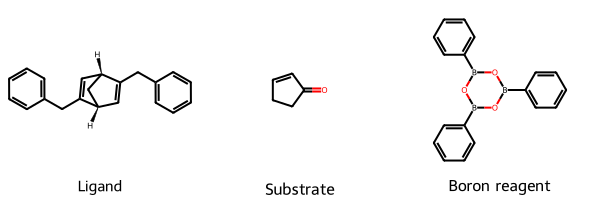

In [3]:
ligands = ChiralLigands(root = '/Users/ed/Documents/PhD_Documents/Annual Review/1st year/Code/ChiralLigands/Data', filename = 'data_aug.csv')

print("Dataset type: ", type(ligands))
print("Dataset node features: ", ligands.num_features)
print("Dataset length: ", ligands.len)
print("Dataset sample: ", ligands[0])
print('Sample features: ',  ligands[0].x)
print('Sample outcome: ',  ligands[0].y)
print('Sample cat: ',  ligands[0].category)

ms = [ligands[0].ligand, ligands[0].substrate, ligands[0].boron]
ms = [Chem.MolFromSmiles(mol) for mol in ms]
Chem.Draw.MolsToGridImage(ms,molsPerRow=3,subImgSize=(200,200),legends=['Ligand', 'Substrate', 'Boron reagent']) 

In [4]:
model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=True)
#model = GAT_loop(ligands.num_features, embedding_size = 64, gnn_layers=3, nheads=1, concat=False)
#model = NN_model(ligands.num_features, ligands.num_edge_features, 50)
model.to(device)

GCN_loop(
  (initial_conv): GCNConv(7, 64)
  (conv_layers): ModuleList(
    (0): GCNConv(64, 64)
  )
  (readout1): Linear(in_features=128, out_features=64, bias=True)
  (readout2): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

In [6]:
categories = np.array([ligands[i].category.detach().numpy() for i in range(len(ligands))])
x = [ligands[i].x.detach().numpy() for i in range(len(ligands))]
groups = [ligands[i].ligand_num for i in range(len(ligands))]

In [7]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, categories)):
    train_idx.append(train)
    test_idx.append(test)

In [8]:
i = 8
train_loader = DataLoader(ligands[train_idx[i]], batch_size=40, shuffle=True)
test_loader = DataLoader(ligands[test_idx[i]], batch_size=40, shuffle=False)

In [9]:
def calculate_metrics(y_pred, y_true, epoch, data):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))

    if epoch % 5 == 0:
        print(data)
        print(f'R2: {r2:.2f}')
        print(f'MAE: {mae:.2f}')
        print(f'RMSE: {rmse:.2f} \n')

    return r2, mae, rmse

In [10]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  #batch.edge_attr,
                  batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))    
      loss.backward()  
      # Update using the gradients
      optimizer.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [11]:
def test(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in test_loader:
      # Use GPU
      batch.to(device)  
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  #batch.edge_attr,
                  batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))    

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [12]:
epochs = 1501
best_loss = 10_000

loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []


for epoch in range (epochs):
            # Training
            model.train()
            loss, pred, label, metrics = train(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if epoch % 5 == 0:
                loss_train.append(loss) 

            if epoch % 100 == 0:
               print(f"Epoch {epoch} | Train Loss {loss}")
               pred_train.append(pred)
               labels_train.append(label)

            if epoch % 5 ==0:
                model.eval()
                loss, pred, label, metrics = test(epoch=epoch)

                if epoch%10 == 0:
                    loss = loss.detach().cpu().numpy()
                    loss_test.append(loss)
            
                if float(loss) < best_loss:
                    best_loss = loss
                    early_stopping_counter = 0
                    best_pred = pred
                    best_y = label
                    best_epoch = epoch
                    best_r2 = metrics[0]
                    best_mae = metrics[1]
                    best_rmse = metrics[2]


    
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Test Loss {loss}")
                pred_test.append(pred)
                labels_test.append(label)
            


train
R2: -0.43
MAE: 46.47
RMSE: 53.97 

Epoch 0 | Train Loss 52.8795280456543
test
R2: -0.05
MAE: 45.81
RMSE: 47.16 

Epoch 0 | Test Loss 47.29460906982422
train
R2: 0.41
MAE: 25.76
RMSE: 34.83 

test
R2: 0.17
MAE: 33.13
RMSE: 41.76 

train
R2: 0.42
MAE: 24.21
RMSE: 34.50 

test
R2: 0.16
MAE: 33.10
RMSE: 42.04 

train
R2: 0.42
MAE: 24.03
RMSE: 34.51 

test
R2: 0.21
MAE: 33.46
RMSE: 40.83 

train
R2: 0.45
MAE: 24.82
RMSE: 33.59 

test
R2: 0.13
MAE: 30.31
RMSE: 42.91 

train
R2: 0.42
MAE: 25.40
RMSE: 34.30 

test
R2: 0.23
MAE: 33.12
RMSE: 40.23 

train
R2: 0.43
MAE: 25.52
RMSE: 34.22 

test
R2: 0.25
MAE: 32.70
RMSE: 39.75 

train
R2: 0.48
MAE: 24.32
RMSE: 32.58 

test
R2: 0.29
MAE: 29.04
RMSE: 38.79 

train
R2: 0.49
MAE: 23.98
RMSE: 32.35 

test
R2: 0.22
MAE: 27.71
RMSE: 40.66 

train
R2: 0.54
MAE: 22.61
RMSE: 30.49 

test
R2: 0.40
MAE: 24.93
RMSE: 35.59 

train
R2: 0.57
MAE: 21.73
RMSE: 29.61 

test
R2: 0.47
MAE: 24.54
RMSE: 33.55 

train
R2: 0.63
MAE: 19.58
RMSE: 27.62 

test
R2: 0.55

In [13]:
print(f'Best test R2: {best_r2}')
print(f'Best test MAE: {best_mae}')
print(f'Best test RMSE: {best_rmse}')
print(f'Best epoch: {best_epoch}')

Best test R2: 0.8898656013873556
Best test MAE: 8.557023048400879
Best test RMSE: 15.242340165336172
Best epoch: 1485


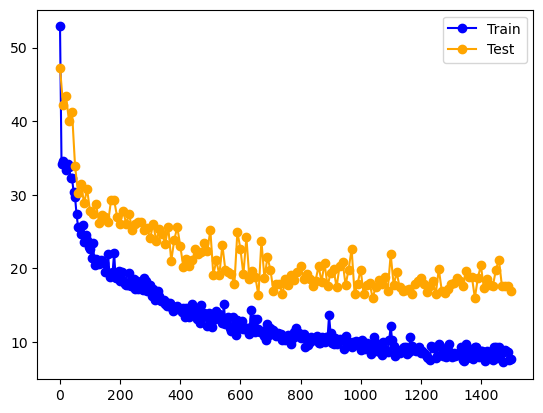

In [14]:
n=0

plt.plot(range(0,epochs,5)[n:], loss_train[n:], 'o-', label = 'Train', color = 'blue')
plt.plot(range(0,epochs,10)[n:], loss_test[n:], 'o-', label = 'Test', color = 'orange')
plt.legend()
plt.show()

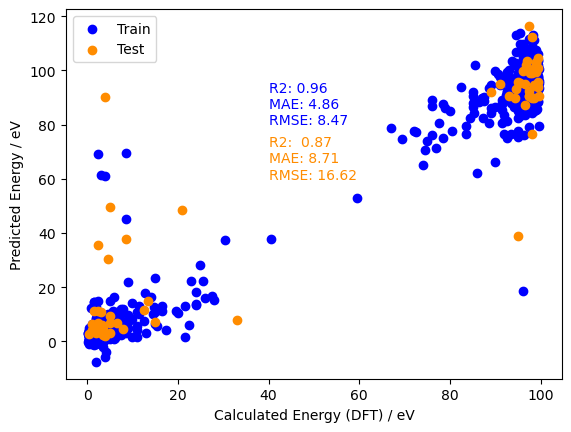

In [15]:
e = 15

plt.scatter(labels_train[e], pred_train[e], color = 'blue', label = 'Train')
plt.scatter(labels_test[e], pred_test[e], color = 'darkorange', label = 'Test')
plt.xlabel("Calculated Energy (DFT) / eV")
plt.ylabel("Predicted Energy / eV")
plt.legend()

plt.text(40, 80, f'R2: {r2_score(labels_train[e], pred_train[e]):.2f} \n\
MAE: {mean_absolute_error(labels_train[e], pred_train[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_train[e], pred_train[e])):.2f}', color = 'b')

plt.text(40, 60, f'R2:  {r2_score(labels_test[e], pred_test[e]):.2f}\n\
MAE: {mean_absolute_error(labels_test[e], pred_test[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_test[e], pred_test[e])):.2f}', color = 'darkorange')
plt.show()

In [16]:
def train_folds(epoch, model, optimiser, loader):

    all_preds = []
    all_y = []

    index = []
    family = []

    ligand = []
    boron = []
    substrate = []

    total_loss = 0
    step = 0

    for batch in loader:

      # Use GPU
      batch.to(device)  

      # Reset gradients
      optimiser.zero_grad() 

      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  #batch.edge_attr,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))    
      loss.backward()  

      # Update using the gradients
      optimiser.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())
      index.append(batch.idx)

      family.append(batch.ligand_fam)

      ligand.append(batch.ligand)
      boron.append(batch.boron)
      substrate.append(batch.substrate)

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    index = np.concatenate(index).ravel()

    family = np.concatenate(family).ravel()

    ligand = np.expand_dims(np.concatenate(ligand).ravel(), 1)
    boron = np.expand_dims(np.concatenate(boron).ravel(),1)
    substrate = np.expand_dims(np.concatenate(substrate).ravel(),1)
    smiles = np.concatenate((ligand, boron, substrate), axis = 1)

    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics, smiles, index, family

In [17]:
def test_folds(epoch, model, loader):

    all_preds = []
    all_y = []

    index = []
    family = []

    ligand = []
    boron = []
    substrate = []

    total_loss = 0
    step = 0

    for batch in loader:

      # Use GPU
      batch.to(device)  

      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  #batch.edge_attr,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y, dim = 1)))

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())
      index.append(batch.idx)

      family.append(batch.ligand_fam)

      ligand.append(batch.ligand)
      boron.append(batch.boron)
      substrate.append(batch.substrate)

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    index = np.concatenate(index).ravel()

    family = np.concatenate(family).ravel()

    ligand = np.expand_dims(np.concatenate(ligand).ravel(), 1)
    boron = np.expand_dims(np.concatenate(boron).ravel(),1)
    substrate = np.expand_dims(np.concatenate(substrate).ravel(),1)
    smiles = np.concatenate((ligand, boron, substrate), axis = 1)

    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics, smiles, index, family

In [18]:
epochs = 1501

#folds x times loss is saved
loss_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
loss_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
r2_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
r2_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
mae_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
mae_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#folds x times loss is saved
rmse_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
rmse_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))

#each element of the list holds a fold, first entry of the np array is the number of data points and second number of times stored
pred_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
pred_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
ee_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
ee_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
smiles_train_folds = [[[[None] *3] * len(train_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 
smiles_test_folds = [[[[None] *3] * len(test_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 

#times lables are saved x number of predictions x folds
index_train_folds = [np.zeros((len(train_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))] 
index_test_folds = [np.zeros((len(test_idx[i]), len(range(0, epochs, 5)))) for i in range(len(train_idx))]

#times lables are saved x number of predictions x folds
family_train_folds = [[[None] * len(train_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 
family_test_folds = [[[None] * len(test_idx[i])] * len(range(0, epochs, 5)) for i in range(len(train_idx))] 


best_loss_f = [None] * len(train_idx)
best_pred_f = [None] * len(train_idx)
best_y_f = [None] * len(train_idx)
best_r2_f = [None] * len(train_idx)
best_mae_f = [None] * len(train_idx)
best_rmse_f = [None] * len(train_idx)
best_epoch_f = [None] * len(train_idx)

In [19]:
for fold in range(len(train_idx)):

    #model = NN_model(ligands.num_features, ligands.num_edge_features, 50)
    model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=False)
    model.to(device)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    train_loader = DataLoader(ligands[train_idx[fold]], batch_size=40, shuffle=True)
    test_loader = DataLoader(ligands[test_idx[fold]], batch_size=40, shuffle=False)

    best_loss = 1_000


    for epoch in range (epochs):

        # Training
        model.train()
        loss, pred, label, metrics, smiles, index, family = train_folds(epoch=epoch,
                                                                model = model,
                                                                optimiser = optimizer,
                                                                loader = train_loader)
        
        loss = loss.detach().cpu().numpy()

        if epoch % 5 == 0:
            loss_train_folds[fold, int(epoch / 5)] = loss
            r2_train_folds[fold, int(epoch / 5)] = metrics[0]
            mae_train_folds[fold, int(epoch / 5)] = metrics[1]
            rmse_train_folds[fold, int(epoch / 5)] = metrics[2]

        if epoch % 5 == 0:
            print(f"Epoch {epoch} | Fold {fold} | Train Loss {loss} \n")
            pred_train_folds[fold][:, int(epoch/5)] = pred
            ee_train_folds[fold][:, int(epoch/5)] = label
            smiles_train_folds[fold][int(epoch/5)] = smiles
            index_train_folds[fold][:, int(epoch/5)] = index
            family_train_folds[fold][int(epoch/5)] = family


        # Testing

        if epoch % 5 == 0:
            model.eval()
            loss, pred, label, metrics, smiles, index, family = test_folds(epoch=epoch,
                                                                   model=model,
                                                                   loader = test_loader)
            loss = loss.detach().cpu().numpy() 

            if float(loss) < best_loss:
                best_loss = loss
                best_loss_f[fold] = loss
                best_pred_f[fold] = pred
                best_y_f[fold] = label
                best_r2_f[fold] = metrics[0]
                best_mae_f[fold] = metrics[1]
                best_rmse_f[fold] = metrics[2]
                best_epoch_f[fold] = epoch

            if epoch % 5 == 0:
                loss_test_folds[fold, int(epoch / 5)] = loss
                r2_test_folds[fold, int(epoch / 5)] = metrics[0]
                mae_test_folds[fold, int(epoch / 5)] = metrics[1]
                rmse_test_folds[fold, int(epoch / 5)] = metrics[2]

                print(f"Epoch {epoch} | Fold {fold} | Test Loss {loss} \n")
                pred_test_folds[fold][:, int(epoch/5)] = pred
                ee_test_folds[fold][:, int(epoch/5)] = label
                smiles_test_folds[fold][int(epoch/5)] = smiles
                index_test_folds[fold][:, int(epoch/5)] = index
                family_test_folds[fold][int(epoch/5)] = family

    
    print(f'Done for fold {fold}')
    print(f'Best loss: {best_loss_f[fold]}')
    print(f'Best r2: {best_r2_f[fold]}')
    print(f'Best mae: {best_mae_f[fold]}')
    print(f'Best rmse: {best_rmse_f[fold]}')
    print(f'Best epoch: {best_epoch_f[fold]}')

train
R2: -0.48
MAE: 47.18
RMSE: 54.94 

Epoch 0 | Fold 0 | Train Loss 54.065364837646484 

test
R2: -0.12
MAE: 45.39
RMSE: 48.65 

Epoch 0 | Fold 0 | Test Loss 48.78594970703125 

train
R2: 0.40
MAE: 25.64
RMSE: 34.97 

Epoch 5 | Fold 0 | Train Loss 34.63375473022461 

test
R2: 0.31
MAE: 30.42
RMSE: 38.28 

Epoch 5 | Fold 0 | Test Loss 38.37295150756836 

train
R2: 0.40
MAE: 25.11
RMSE: 34.91 

Epoch 10 | Fold 0 | Train Loss 34.2025260925293 

test
R2: 0.31
MAE: 30.37
RMSE: 38.01 

Epoch 10 | Fold 0 | Test Loss 38.01818084716797 

train
R2: 0.39
MAE: 25.93
RMSE: 35.18 

Epoch 15 | Fold 0 | Train Loss 34.16428756713867 

test
R2: 0.32
MAE: 28.96
RMSE: 37.99 

Epoch 15 | Fold 0 | Test Loss 38.181060791015625 

train
R2: 0.40
MAE: 26.23
RMSE: 34.88 

Epoch 20 | Fold 0 | Train Loss 34.845787048339844 

test
R2: 0.28
MAE: 29.15
RMSE: 38.85 

Epoch 20 | Fold 0 | Test Loss 39.13880920410156 

train
R2: 0.37
MAE: 28.11
RMSE: 35.86 

Epoch 25 | Fold 0 | Train Loss 35.48122787475586 

test
R2: 

In [20]:
mean_r2_test = []
std_r2_test = []

mean_mae_test = []
std_mae_test = []

mean_rmse_test = []
std_rmse_test = []

for i in range(len(range(0,epochs,5))):

    mean_r2_test.append(np.mean(r2_test_folds[:,i]))
    std_r2_test.append(np.std(r2_test_folds[:,i]))

    mean_mae_test.append(np.mean(mae_test_folds[:,i]))
    std_mae_test.append(np.std(mae_test_folds[:,i]))

    mean_rmse_test.append(np.mean(rmse_test_folds[:,i]))
    std_rmse_test.append(np.mean(rmse_test_folds[:,i]))

In [21]:
print(f'e value for best r2: {mean_r2_test.index(max(mean_r2_test))}')
print(f'e value for best mae: {mean_mae_test.index(min(mean_mae_test))}')
print(f'e value for best rmse: {mean_rmse_test.index(min(mean_rmse_test))}')

all = [sum(x) for x in zip(mean_mae_test, mean_rmse_test)]
print(f'e value for best General: {all.index(min(all))}')

e value for best r2: 273
e value for best mae: 273
e value for best rmse: 273
e value for best General: 273


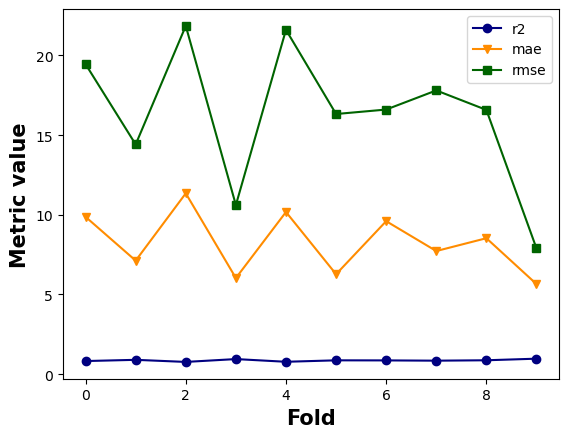

In [22]:
e = 273
plt.plot(figsize =(24, 16))
plt.plot(range(len(train_idx)), r2_test_folds[:,e], 'o-', label = 'r2', color = 'navy')
plt.plot(range(len(train_idx)), mae_test_folds[:,e], 'v-', label = 'mae', color = 'darkorange')
plt.plot(range(len(train_idx)), rmse_test_folds[:,e], 's-', label = 'rmse', color = 'darkgreen')


plt.xlabel('Fold', fontweight ='bold', fontsize = 15)
plt.ylabel('Metric value', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

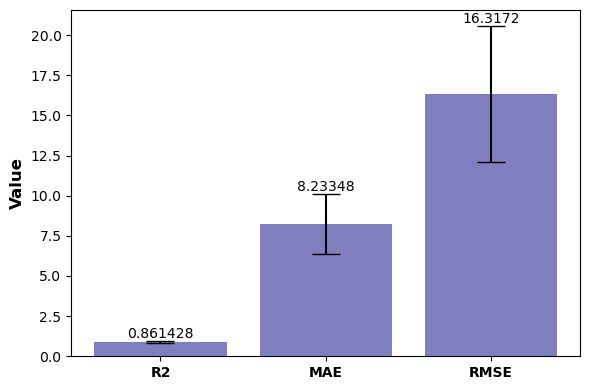

In [26]:
e = 273
Metrics = ['R2', 'MAE', 'RMSE']
x_pos = np.arange(len(Metrics))
CTEs = [np.mean(r2_test_folds[:,e]), np.mean(mae_test_folds[:,e]), np.mean(rmse_test_folds[:,e])]
error = [np.std(r2_test_folds[:,e]), np.std(mae_test_folds[:,e]), np.std(rmse_test_folds[:,e])]

fig, ax = plt.subplots(figsize =(6, 4))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', color = 'navy', alpha=.5, ecolor='black', capsize=10)
ax.set_ylabel('Value', fontweight ='bold', fontsize = 12)
ax.bar_label(bars)
ax.set_xticks(x_pos)
ax.set_xticklabels(Metrics, fontweight ='bold' ,fontsize = 10)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()

In [27]:
e = 273
df = pd.DataFrame()

for f in range(len(train_idx)):
    fs = [f for _ in range(len(test_idx[f]))]
    data_set = ['test' for _ in range(len(test_idx[f]))]

    data = {
        'ee': ee_test_folds[f][:,e],
        'Prediction': pred_test_folds[f][:,e],
        'Ligand': smiles_test_folds[f][e][:,0],
        'Boron_reagent': smiles_test_folds[f][e][:,1],
        'Substrate': smiles_test_folds[f][e][:,2], 
        'family': family_test_folds[f][e],
        'index': index_test_folds[f][:,e],
        'fold': f,
        'set': data_set
    }

    df_f = pd.DataFrame(data)
    df = pd.concat([df, df_f], axis = 0)

    data_set = ['train' for _ in range(len(train_idx[f]))]

    data = {
    'ee': ee_train_folds[f][:,e],
    'Prediction': pred_train_folds[f][:,e],
    'Ligand': smiles_train_folds[f][e][:,0],
    'Boron_reagent': smiles_train_folds[f][e][:,1],
    'Substrate': smiles_train_folds[f][e][:,2], 
    'family': family_train_folds[f][e],
    'index': index_train_folds[f][:,e],
    'fold': f,
    'set': data_set
    }

    df_f = pd.DataFrame(data)
    df = pd.concat([df, df_f], axis = 0)



df = df.set_index('index')
df['error'] = df['ee'] - df['Prediction']
df

,ee,Prediction,Ligand,Boron_reagent,Substrate,family,fold,set,error
index,,,,,,,,,
9.0,2.250000,3.363006,C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2,OB(O)c1ccccc1,CC(=O)/C=C/C(C)C,fam1,0,test,-1.113006
15.0,15.000000,22.026600,C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2,OB(O)c1ccccc1,CN1C(=O)C=CC1=O,fam1,0,test,-7.026600
27.0,1.000000,5.552246,CC1(C)[C@@H]2C=C(c3ccccc3)[C@@]1(C)C=C2c1ccccc1,OB(O)c1ccc(-c2ccccc2)cc1,CC(C)(C)OC(=O)/C=C/C(=O)OC(C)(C)C,fam2,0,test,-4.552246
31.0,1.750000,5.810474,CC1(C)[C@@H]2C=C(c3ccccc3)[C@@]1(C)C=C2c1ccccc1,OB(O)c1cccc2ccccc12,CC(C)(C)OC(=O)/C=C/C(=O)OC(C)(C)C,fam2,0,test,-4.060474
37.0,11.000000,4.286033,CC(C)(C)c1ccc(C2=C[C@]3(C)C(c4ccc(C(C)(C)C)cc4...,OB(O)c1ccccc1,CC(=O)/C=C/C(C)C,fam2,0,test,6.713967
...,...,...,...,...,...,...,...,...,...
596.0,99.000000,98.645523,CO[C@]1(C)C[C@@]2(C)C=C(Cc3ccccc3)[C@@H]1C=C2C...,OB(O)c1ccccc1,Cc1ccc2oc(=O)ccc2c1,fam6,9,train,0.354477
307.0,97.500000,47.524250,CC1=C[C@@H]2C(C(C)(C)O)=C[C@H]1C[C@@H]2C(C)C,OB(O)c1ccccc1,CCCCC/C=C/C(C)=O,fam7,9,train,49.975750
671.0,97.500000,101.819672,CC1=C[C@H]2C(C(=O)N(Cc3ccccc3)Cc3ccccc3)=C[C@@...,Cc1ccc(O)c(B2OC(C)(C)C(C)(C)O2)c1,CCC/C=C/c1ncc(C(F)(F)F)cc1Cl,fam7,9,train,-4.319672


In [28]:
df.to_csv(f'/Users/ed/Documents/PhD_Documents/Annual Review/1st year/Code/ChiralLigands/Analyse_results/plots_regr/ligands_allfolds_e{e}_NN_epochs_{e*5}.csv')